# Tutorial on advanced topics

## Setting up the environment
It is assumed you are familiar with basics of the library. If not - see _"Tutorial on basic topics"_.

In [1]:
import pymice as pm
import glob

pm.getTutorialData(quiet=True)

dataFiles = glob.glob('C57_AB/*.zip')

PyMICE library v. 0.2.4
(Resource identifier: RRID:nlx_158570)

This is a bleeding edge version of the library. It might meet your
expectations, however it might also go to your fridge, drink all the
beer it can find there and then eat your cat. Be warned.



## Visits order
Visit objects returned by _`.getVisits()`_ method are not ordered by default, which means they might be in a random order. In an extremal case the order may be different for every call of the method!

Of course it is possible to sort the returned list, however it is also possible to have it already ordered by attribute(s) indicated by the _`order`_ parameter of the method.

### Visits ordered by one attribute
To have the list ordered by one attribute pass the name of the attribute as the _`order`_ parameter.

In [2]:
ml = pm.Loader('C57_AB/2012-08-28 15.33.58.zip')
visits = ml.getVisits(order='Start')
for visit in visits[:5]:
    print visit.Start

2012-08-28 15:34:14.140000+02:00
2012-08-28 15:34:18.625000+02:00
2012-08-28 15:34:27.375000+02:00
2012-08-28 15:34:40.140000+02:00
2012-08-28 15:34:42.171000+02:00


### Visits ordered by a nested attribute
Since some attributes (e.g. _`.Animal`_) are objects with their own attributes, it is also possible to have the list sorted by such "nested" attributes (e.g. _`.Animal.Name`_).

In [3]:
visits = ml.getVisits(order='Animal.Name')
for visit in visits[::500]:
    print visit.Animal.Name

C57 A 1
C57 A 10
C57 A 11
C57 A 2
C57 A 3
C57 A 4
C57 A 6
C57 A 8
C57 A 9
C57 B 1
C57 B 10
C57 B 12
C57 B 2
C57 B 4
C57 B 5
C57 B 9


### Visits ordered by multiple attributes
It is possible to have visits ordered firstly by one attibute, then by another one (and so on) by passing a sequence of attribute names as _`order`_ parameter.

In [4]:
visits = ml.getVisits(order=('Cage', 'Corner'))
for visit in visits[::500]:
    print visit.Cage, visit.Corner

1 1
1 1
1 2
1 3
1 3
1 4
1 4
2 1
2 2
2 2
2 2
2 2
2 3
2 3
2 4
2 4


## Visit selection
Usually only a subset of recorded visits is meaningful for certain analysis. The library provides methods for selection of such subsets.

### Visits of a particular mouse
It is common to analyse visits of cetrain animal.

To select visits of a particular mouse pass its name as the _`mice`_ parameter of _`.getVisits()`_ method.

In [5]:
visits = ml.getVisits(mice='C57 A 1')
print len(visits)
print visits[321].Animal

493
C57 A 1


### Visits of a group of mice
The _`mice`_ parameter accepts also multiple names.

In [6]:
visits = ml.getVisits(mice=['C57 A 1', 'C57 A 2'])
visitorNames = [v.Animal.Name for v in visits]
for mouse in set(visitorNames):
    print '%s: %d visits' % (mouse, visitorNames.count(mouse))

C57 A 1: 493 visits
C57 A 2: 281 visits


### Visits performed at particular time
Analyses are very often focused on a certain time period (e.g. phase of experiment phase).

To select visits before or after particular time you can use (respectively) _`start`_ and _`end`_ parameters of _`getVisits()`_ method.

In the example visits started between 15:00 (inclusive) and 16:00 (exclusive) 28th August 2012 are being selected.
**The time is given as _Eastern European Time_ (EET).**

In [7]:
from datetime import datetime
import pytz

EET = pytz.timezone('Etc/GMT-2')

timeFrom = datetime(2012, 8, 28, 15, 0, tzinfo=EET)
timeTo = datetime(2012, 8, 28, 16, 0, tzinfo=EET)

visits = ml.getVisits(start=timeFrom, end=timeTo)
print min(v.Start for v in visits)
print max(v.Start for v in visits)


2012-08-28 15:34:14.140000+02:00
2012-08-28 15:59:48.546000+02:00


## Experiment timeline configuration file
It is rather inconvenient to have starts and ends of time periods hardcoded in the source code. It would be much more convenient to have the time periods defined in a configuration file.

To aid that purpose library provides _`ExperimentTimeline`_ class for loading such files. The class inherits from both [_`ConfigParser.RawConfigParser`_ class of The Python Standard Library](https://docs.python.org/2/library/configparser.html#rawconfigparser-objects) and [_`matplotlib.ticker.Formatter`_ class of matplotlib library](http://matplotlib.org/api/ticker_api.html#matplotlib.ticker.Formatter).

### File format
The format of the file is an adaptation of [INI format](https://en.wikipedia.org/wiki/INI_file). To be more specific, it is the format supported by the [_`ConfigParser`_ module of The Python Standard Library](https://docs.python.org/2/library/configparser.html).

Every section of the file describes a time period with following properties:
* `start` - a start time of the period in `YYYY-MM-DD HH:MM` or `YYYY-MM-DD HH:MM:SS` format,
* `end` - an end time of the period in `YYYY-MM-DD HH:MM` or `YYYY-MM-DD HH:MM:SS` format,
* `tzinfo` - a name of timezone used by `start` and `end` property (it has to be recognizable by [_`timezone`_ function of the _`pytz`_ module](http://pytz.sourceforge.net/)).

A configuration file might look like this:
```
[SA 1 dark]
start = 2012-08-28 13:00
end = 2012-08-29 01:00
tzinfo = Etc/GMT-2

[SA 1 light]
start = 2012-08-29 01:00
end = 2012-08-29 13:00
tzinfo = Etc/GMT-2
```

### Loading a configuration file
To load a configuration file pass a path to it to the class constructor. Then you will be able to list defined time period (with _`.sections()`_ method) and get their boundaries (with _`.getTime()`_ method).

In [8]:
experimentTimeline = pm.ExperimentTimeline('C57_AB/timeline.ini')

for timePeriod in experimentTimeline.sections():
    start, end = experimentTimeline.getTime(timePeriod)
    print "%s:\t%s - %s" % (timePeriod, start, end)

SA 1 dark:	2012-08-28 13:00:00+02:00 - 2012-08-29 01:00:00+02:00
SA 1 light:	2012-08-29 01:00:00+02:00 - 2012-08-29 13:00:00+02:00
SA 2 dark:	2012-08-29 13:00:00+02:00 - 2012-08-30 01:00:00+02:00
SA 2 light:	2012-08-30 01:00:00+02:00 - 2012-08-30 13:00:00+02:00
SA 3 dark:	2012-08-30 13:00:00+02:00 - 2012-08-31 01:00:00+02:00
SA 3 light:	2012-08-31 01:00:00+02:00 - 2012-08-31 13:00:00+02:00
SA 4 dark:	2012-08-31 13:00:00+02:00 - 2012-09-01 01:00:00+02:00
SA 4 light:	2012-09-01 01:00:00+02:00 - 2012-09-01 13:00:00+02:00
SA 5 dark:	2012-09-01 13:00:00+02:00 - 2012-09-02 01:00:00+02:00
SA 5 light:	2012-09-02 01:00:00+02:00 - 2012-09-02 13:00:00+02:00
NPA 1 dark:	2012-09-02 13:00:00+02:00 - 2012-09-03 01:00:00+02:00
NPA 1 light:	2012-09-03 01:00:00+02:00 - 2012-09-03 13:00:00+02:00
NPA 2 dark:	2012-09-03 13:00:00+02:00 - 2012-09-04 01:00:00+02:00
NPA 2 light:	2012-09-04 01:00:00+02:00 - 2012-09-04 13:00:00+02:00
Place Pref 1 dark:	2012-09-04 13:00:00+02:00 - 2012-09-05 01:00:00+02:00
Place 

### Boundaries of many time periods
To get boundaries of a minimal time period covering several time periods defined in the config file pass a collection of their names as a parameter of _`.getTime()`_ method.

In [9]:
start, end = experimentTimeline.getTime(['Place Pref 1 dark',
                                       'Place Pref 3 light'])
print '%s - %s' % (start, end)

2012-09-04 13:00:00+02:00 - 2012-09-07 13:00:00+02:00


### Debugging a configuration file
You might want to verify whether every time period defined in the file is defined as it was supposed to be. A simplest way for that is screening the file with the _`plotPhases()`_ function of the _`pymice.debug`_ module.

IPython Notebook notes:
* `%matplotlib inline` is a directive of [IPython Notebook](http://ipython.org/notebook.html) necessary to display the image,
* `_` intercepts a [matplotlib.figure.Figure](http://matplotlib.org/api/figure_api.html#matplotlib.figure.Figure) instance returned by the function in order not to display the image twice.

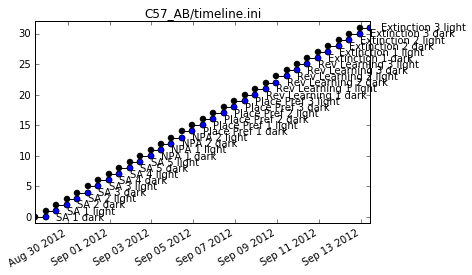

In [10]:
%matplotlib inline

import pymice.debug as pmd
_ = pmd.plotPhases(experimentTimeline)

## Customising loaded data
### Omitting nosepoke data loading
In order to speed up the loading process you might disable loading of nosepoke data (if they are not necessary) by setting getNp option to False.

In [11]:
ml = pm.Loader('C57_AB/2012-08-28 15.33.58.zip', getNp=False)
visits = ml.getVisits(order=('Start', 'End'))
visit = visits[4]
print visit.Nosepokes

None


### Loading additional data
No log, environment nor hardware events data are loaded unless the loader is explicitely told to do so.

In [12]:
print ml.getLog()
print ml.getEnvironment()
print ml.getHardwareEvents()
ml = pm.Loader('C57_AB/2012-08-28 15.33.58.zip', getLog=True, getHw=True, getEnv=True)
print len(ml.getLog())
print len(ml.getEnvironment())
print len(ml.getHardwareEvents())

[]
[]
[]
1220
12273
177


## Data validity tests

It is important to be sure the data you are going to analyse are valid. For that purpose log analysis is necessary.

### Data validator and log analyzers
Log analysis is being performed by a `DataValidator` object with a collection of log analyzers given as arguments of its constructor.

Instances of _`LickometerLogAnalyzer`_ class checks log for lickometer problems while _`PresenceLogAnalyzer`_ - for presence of unidentified animal.

Remember that for log analysis log data must be loaded (_`getLog`_ flag of constructors od _`Loader`_ and _`Merger`_ objects must be set to _`True`_).

In [13]:
loaders = [pm.Loader(filename, getLog=True) for filename in dataFiles]
mm = pm.Merger(*loaders, getLog=True)

dataValidator = pm.DataValidator(pm.LickometerLogAnalyzer(),
                                 pm.PresenceLogAnalyzer())
validatorReport = dataValidator(mm)

### Results of log analysis
After the analysis is performed, you can use _`TestMiceData`_ objects to check, if there is no problem with data in a period of interest (POI).

The POI in the example is defined as a period from first to last registration (obtained with _`getStart()`_ and _`getEnd()`_ methods).

In [14]:
start = mm.getStart()
end = mm.getEnd()
interval = (start, end)

strInterval = '(from %s to %s)' % interval

lickometerTester = pm.TestMiceData('Lickometer')
presenceTester = pm.TestMiceData('Presence')
if lickometerTester(validatorReport, interval):
    print "lickometer ok " + strInterval
    
else:
    print "lickometer problem " + strInterval
    
if presenceTester(validatorReport, interval):
    print "presences ok " + strInterval
    
else:
    print "unknown mice presence problem " + strInterval
    

lickometer problem (from 2012-08-28 13:44:52.671000+02:00 to 2012-09-13 13:35:34.390000+02:00)
presences ok (from 2012-08-28 13:44:52.671000+02:00 to 2012-09-13 13:35:34.390000+02:00)
